As mentioned in [our notebook on Decision Trees](https://napsterinblue.github.io/notes/machine_learning/trees/decision_tree_basics/) we can apply hard stops such as `max_depth`, `max_leaf_nodes`, or `min_samples_leaf` to enforce hard-and-fast rules we employ when fitting our Decision Trees to prevent them from growing unruly and thus overfitting.

Alternatively, Chapter 8 of ISL proposes a process called *Cost Complexity Pruning*, which acts as a sort of countermeasure for paring down a large tree that was trained more-or-less unpenalized. The method employs a constant `alpha` that penalizes our cost function for each of our terminal nodes for a given tree, denoted as `|T|`.

The Regression case looks like:

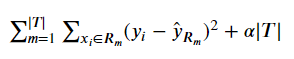

In [2]:
from IPython.display import Image

Image('images/regression_cost_prune.PNG')

(Obviously, the Classification has the same term at the end, just a more-appropriate loss function.)

They go on to state an interesting property of this form

>As we increase `alpha` from zero, branches get pruned from the tree in a predictable fashion, so obtaining the whole sequence of subtrees as a function of `alpha` is easy.

I really like [this video's explanation of that intuition](https://www.youtube.com/watch?v=wpkGWZwJUTU).

## In `scikit-learn`

----------

**Note**: This section is only relevant as of version `0.22`.

At the time of writing this, the docs regarding this feature aren't live yet, so I'll borrow heavier than usual in lieu of being able to link a permanent URL.

Otherwise, let's jump into it.

---------

We draw on a sample dataset used for classification problems

In [1]:
%pylab inline

from yellowbrick.datasets import load_credit

X, y = load_credit()

Populating the interactive namespace from numpy and matplotlib


In [2]:
X.head()

,limit,sex,edu,married,age,apr_delay,may_delay,jun_delay,jul_delay,aug_delay,...,jun_bill,jul_bill,aug_bill,sep_bill,apr_pay,may_pay,jun_pay,jul_pay,aug_pay,sep_pay
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


And we can just sausage it right into a Decision Tree with `sklearn`

In [3]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

And if we fit it with the default arguments, we'd wind up getting a tree that had 4750 terminal nodes

In [4]:
clf.get_n_leaves()

4750

On the otherhand, if we re-instantiated `clf` as a blank `DecisionTreeClassifier`

In [5]:
clf = DecisionTreeClassifier(random_state=0)

And called `.cost_complexity_pruning_path()` instead of `fit()`

In [6]:
path = clf.cost_complexity_pruning_path(X, y)

Behind the scenes this actually fits the generic Decision Tree, then iteratively ratchets up our `alpha` value and aggregates the *impurities* of each terminal node. The `path` variable gets loaded with arrays `ccp_alphas` and `impurities`-- the values of `alpha` that cause changes in the impurities and their corresponding results.

In [7]:
path.ccp_alphas

array([0.00000000e+00, 0.00000000e+00, 6.48148148e-06, ...,
       3.34121368e-03, 1.03500728e-02, 5.24158517e-02])

In [8]:
path.impurities

array([0.00074444, 0.00074444, 0.00076389, ..., 0.2817752 , 0.29212527,
       0.34454112])

We wind up finding `1899` different values for `alpha`

In [9]:
len(path.ccp_alphas)

1889

And look at how sensitive impurity is to different alpha values-- check that x-scale!

(-0.0001, 0.0005)

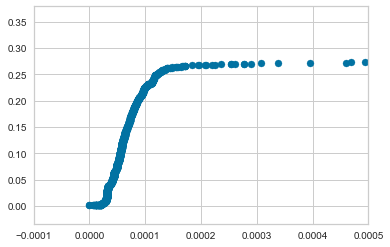

In [10]:
fix, ax = plt.subplots()
ax.scatter(path.ccp_alphas, path.impurities)
ax.set_xlim([-0.0001, 0.0005])

To cement our intuition here, let's train a couple hundred Decision Trees using increasing values of `alpha`

In [11]:
clfs = []
for ccp_alpha in path.ccp_alphas[::10]:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)

It should be obvious that "penalize complexity with high values of `alpha`" leads a consistent decrease in the number of terminal nodes as well as the depth of our Decision Trees

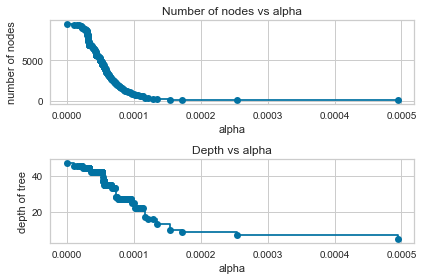

In [12]:
ccp_alphas = path.ccp_alphas[::10]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Finally, as with everything in ISL, determining the right value of `alpha` *for you* is a matter of setting up the appropriate Cross Validation routine.